In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

shape_path = 'cb_2018_us_state_20m.shp'

shape = gpd.read_file(shape_path)
print(shape.head())

  STATEFP   STATENS     AFFGEOID GEOID STUSPS          NAME LSAD  \
0      24  01714934  0400000US24    24     MD      Maryland   00   
1      19  01779785  0400000US19    19     IA          Iowa   00   
2      10  01779781  0400000US10    10     DE      Delaware   00   
3      39  01085497  0400000US39    39     OH          Ohio   00   
4      42  01779798  0400000US42    42     PA  Pennsylvania   00   

          ALAND       AWATER  \
0   25151100280   6979966958   
1  144661267977   1084180812   
2    5045925646   1399985648   
3  105828882568  10268850702   
4  115884442321   3394589990   

                                            geometry  
0  MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...  
1  POLYGON ((-96.62187 42.77925, -96.57794 42.827...  
2  POLYGON ((-75.77379 39.72220, -75.75323 39.757...  
3  MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...  
4  POLYGON ((-80.51989 40.90666, -80.51964 40.987...  


In [2]:
shape = shape.dropna()
shape = shape[~shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

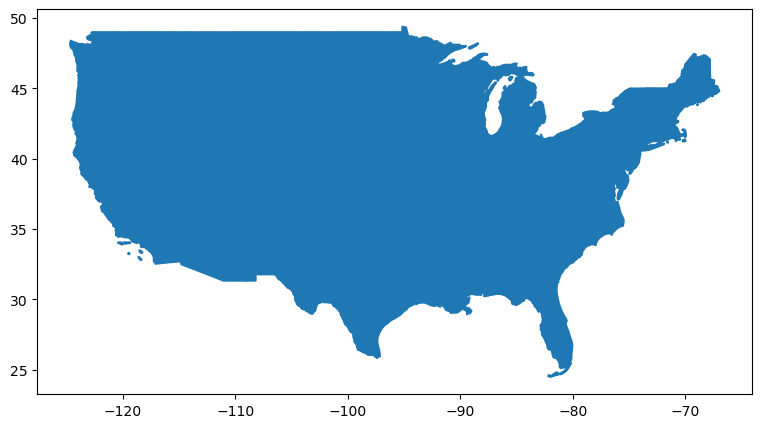

In [3]:
ax = shape.boundary.plot(figsize=(10, 5))
shape.plot(ax=ax, legend=True)

plt.show()

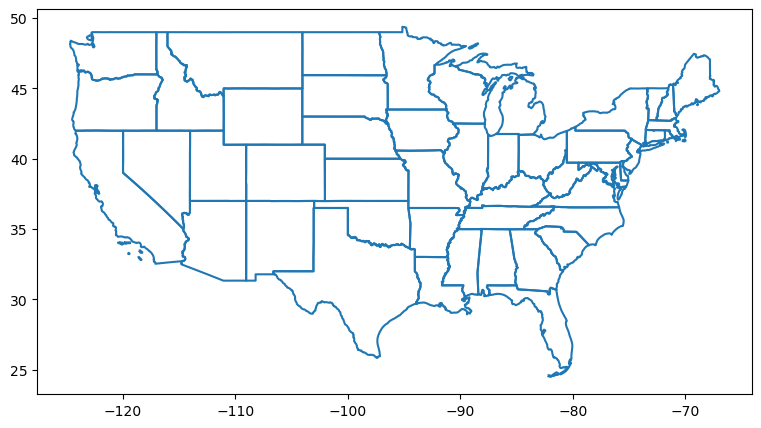

In [4]:
shape.boundary.plot(figsize=(10, 5))
plt.show()

In [5]:
pd_cities = pd.read_csv('test_data_2.csv')
cities = gpd.GeoDataFrame(
    pd_cities, geometry=gpd.points_from_xy(pd_cities.Longitude, pd_cities.Latitude))
cities.crs = 'EPSG:4326'
cities = cities.to_crs(shape.crs)

cities.head()

,Latitude,Longitude,geometry
0,33.60094,-86.95611,POINT (-86.95611 33.60094)


In [9]:
# cities dataframe treatment

uscities = pd.read_csv('uscities.csv')

uscities = uscities[["city", "state_id", "lat", "lng"]]

uscities.head()

,city,state_id,lat,lng
0,City of Industry,CA,34.0050,-117.939
1,Avon,CT,41.7944,-72.8578
2,Branford,CT,41.2778,-72.7997
3,Cromwell,CT,41.5950,-72.6453
4,East Windsor,CT,41.9167,-72.5578


In [11]:
# checking cities btw the two df (uscities and modified fandom)

df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

n_tot = 0
for state in df.State.unique():
    for city in df[df.State == state].Town.unique():
        if city not in uscities[uscities.state_id == state].city.unique() :
            n_tot+=1
print(n_tot)

0


In [36]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

#modifying fandom df

#Store_id,State,Town,Street,Category,Opening_date,Closing_date

#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-01')&(df.Opening_date<'2017-01-01')
df['closed_2016'] = (df.Closing_date>='2016-01-01')&(df.Closing_date<'2017-01-01')

#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()


C:\Users\inesn\AppData\Local\Temp\ipykernel_16100\644086837.py:13: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()
C:\Users\inesn\AppData\Local\Temp\ipykernel_16100\644086837.py:13: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Store_id,State,Town,Street,Category,Opening_date,Closing_date,opened_2016,closed_2016
count,312,312,312,312,312,213,153,312,312
unique,311,35,274,312,5,50,9,2,2
top,883,TX,San Antonio,1810 Shug Jordan Pkwy,Neighborhood Market,2016-01-27 00:00:00,2016-01-28 00:00:00,True,False
freq,2,60,5,1,246,29,118,166,166
first,NaN,NaN,NaN,NaN,NaN,1900-01-01 00:00:00,2016-01-17 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2016-12-07 00:00:00,2022-01-01 00:00:00,NaN,NaN


In [37]:
#designing the red-orange-green color code

df2 = df.groupby(['Town','State'])['opened_2016'].any().rename('opened_2016_city').to_frame()
df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
df4['opened_and_closed_2016_city']=df4.opened_2016_city & df4.closed_2016_city
df4.head()

,,opened_2016_city,closed_2016_city,opened_and_closed_2016_city
Town,State,,,
Abbeville,AL,False,True,False
Abilene,TX,True,False,False
Abingdon,VA,True,False,False
Adel,GA,True,False,False
Alamogordo,NM,True,False,False


In [38]:
df5 = df4.merge(df, how = "outer", on = ['Town','State'])
df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
#aggregation_functions = {'Town': 'first', 'State': 'second', 'opened_2016_city': 'third' ,'closed_2016_city': 'fourth','opened_and_closed_2016_city': 'fifth','town': 'sum'}
#df_new = df5.groupby(df5[['Town','State']]).aggregate(aggregation_functions)
df5.head()

,Town,State,opened_2016_city,closed_2016_city,opened_and_closed_2016_city
0,Abbeville,AL,False,True,False
1,Abilene,TX,True,False,False
2,Abingdon,VA,True,False,False
3,Adel,GA,True,False,False
4,Alamogordo,NM,True,False,False


In [39]:
#merging the 2 dfs

map_data = pd.merge(df5, uscities,  how='inner', left_on=['Town','State'], right_on = ['city','state_id'])

#removing unnecessary columns ('Town', 'State')

map_data = map_data[['city','lat','lng','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]

def colors(x):
    if x == 1 :
        return 'g'
    if x == 2 :
        return 'r'
    return 'b'

colors_v = np.vectorize(colors)

map_data['value']= 1*map_data['opened_2016_city']+2*map_data['closed_2016_city']+3*map_data['opened_and_closed_2016_city']
map_data['color']=colors_v(map_data['value'])
map_data.describe()



,lat,value
count,313.000000,313.000000
mean,34.163656,1.511182
std,3.983202,0.665570
min,25.997500,1.000000
25%,31.577600,1.000000
50%,34.114100,1.000000
75%,35.975100,2.000000
max,58.454600,6.000000


### New code for the map

In [18]:
df = pd.read_csv(r'C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\fandom_traitées.csv', parse_dates = ["Opening_date", "Closing_date"])

In [22]:
#creating boolean columns for entry/exit in 2016 (no entry and exit in 2016 for a single store)
df['opened_2016'] = (df.Opening_date>='2016-01-01')&(df.Opening_date<'2017-01-01')
df['closed_2016'] = (df.Closing_date>='2016-01-01')&(df.Closing_date<'2017-01-01')

In [23]:
#keeping only stores with entry/exit in 2016
df = df[df.opened_2016 | df.closed_2016]
df.describe()

C:\Users\inesn\AppData\Local\Temp\ipykernel_19712\1744285901.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()
C:\Users\inesn\AppData\Local\Temp\ipykernel_19712\1744285901.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Store_id,State,Town,Street,Category,Opening_date,Closing_date,opened_2016,closed_2016
count,312,312,312,312,312,213,153,312,312
unique,311,35,274,312,5,50,9,2,2
top,883,TX,San Antonio,1810 Shug Jordan Pkwy,Neighborhood Market,2016-01-27 00:00:00,2016-01-28 00:00:00,True,False
freq,2,60,5,1,246,29,118,166,166
first,NaN,NaN,NaN,NaN,NaN,1900-01-01 00:00:00,2016-01-17 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2016-12-07 00:00:00,2022-01-01 00:00:00,NaN,NaN


In [48]:
#designing the red-orange-green color code
df2 = df.groupby(['Town','State'])['Store_id'].count()
df2[df2>=2].head(30)

Town           State
Auburn         AL       2
Charlotte      NC       2
Chattanooga    TN       2
Chicago        IL       2
Columbia       SC       2
Columbus       GA       3
Hollywood      FL       2
Hot Springs    AR       2
Houston        TX       3
Huntsville     AL       3
Killeen        TX       2
Los Angeles    CA       2
Lubbock        TX       2
Montgomery     AL       2
Murfreesboro   TN       2
Myrtle Beach   SC       2
Oklahoma City  OK       2
Orlando        FL       2
San Angelo     TX       2
San Antonio    TX       5
Shreveport     LA       2
Spring         TX       2
St. Peters     MO       2
Tyler          TX       2
Wichita        KS       3
Name: Store_id, dtype: int64

<AxesSubplot: >

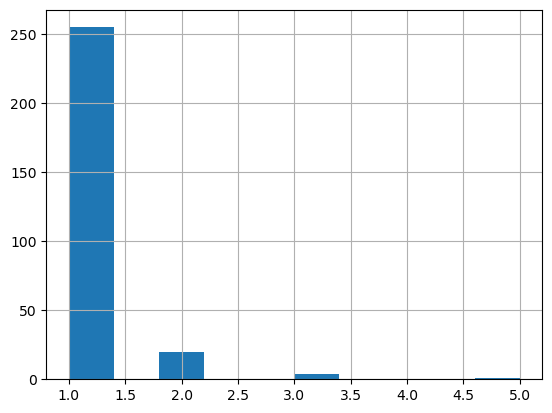

In [49]:
df2.hist()

In [51]:
df2.describe()

,opened_2016_city
count,280
unique,2
top,False
freq,140


In [52]:
#designing the red-orange-green color code
df2 = df.groupby(['Town','State'])['opened_2016'].any().rename('opened_2016_city').to_frame()
df2.describe()

,opened_2016_city
count,280
unique,2
top,False
freq,140


In [53]:
df3 = df.groupby(['Town','State'])['closed_2016'].any().rename('closed_2016_city').to_frame()
df3.describe()

,closed_2016_city
count,280
unique,2
top,True
freq,141


In [ ]:
df4 = df2.merge(df3, how = "outer", on = ['Town','State'])
df4['opened_and_closed_2016_city']=df4.opened_2016_city & df4.closed_2016_city
df4.describe()

In [ ]:
df5 = df4.merge(df, how = "outer", on = ['Town','State'])
df5=df5[['Town','State','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]
#aggregation_functions = {'Town': 'first', 'State': 'second', 'opened_2016_city': 'third' ,'closed_2016_city': 'fourth','opened_and_closed_2016_city': 'fifth','town': 'sum'}
#df_new = df5.groupby(df5[['Town','State']]).aggregate(aggregation_functions)
df5.head()

In [40]:
geo_map_data = gpd.GeoDataFrame(
    map_data, geometry=gpd.points_from_xy(map_data.lng, map_data.lat))
geo_map_data.crs = 'EPSG:4326'
geo_map_data = geo_map_data.to_crs(shape.crs)

geo_map_data.head()

#removing unnecessary columns ('Town', 'State')

map_data = map_data[['city','lat','lng','opened_2016_city','closed_2016_city','opened_and_closed_2016_city']]

def colors(x):
    if x == 1 :
        return 'g'
    if x == 2 :
        return 'r'
    return 'b'

colors_v = np.vectorize(colors)

map_data['value']= 1*map_data['opened_2016_city']+2*map_data['closed_2016_city']+3*map_data['opened_and_closed_2016_city']
map_data['color']=colors_v(map_data['value'])
map_data.describe()

,city,lat,lng,opened_2016_city,closed_2016_city,opened_and_closed_2016_city,value,color,geometry
0,Abbeville,31.5664,-85.2528,False,True,False,2,r,POINT (-85.25280 31.56640)
1,Abilene,32.4543,-99.7384,True,False,False,1,g,POINT (-99.73840 32.45430)
2,Abingdon,36.7090,-81.9713,True,False,False,1,g,POINT (-81.97130 36.70900)
3,Adel,31.1264,-83.4229,True,False,False,1,g,POINT (-83.42290 31.12640)
4,Alamogordo,32.8837,-105.9625,True,False,False,1,g,POINT (-105.96250 32.88370)


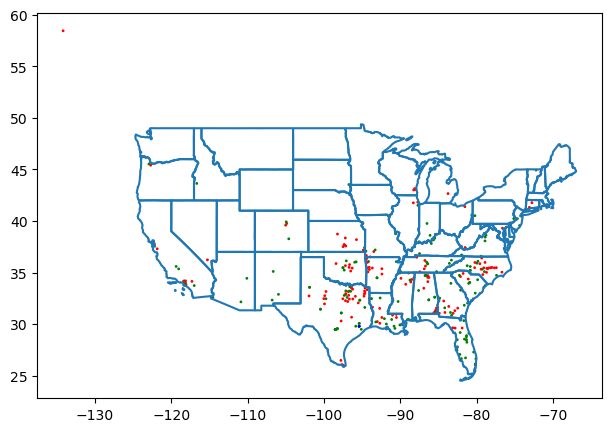

In [41]:
base = shape.boundary.plot(figsize=(10, 5))

geo_map_data.plot(ax=base, marker='o', color=geo_map_data['color'], markersize=1);

plt.show()

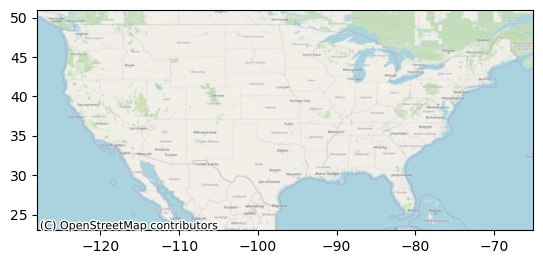

In [14]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

#création des couleurs/tailles de points
def couleur(a): # couleur d'un point du graphique en fonction de a la date du séisme en km
    if a == "opened":
        return 'purple'
    elif a == "closed":
        return 'blue'
    elif a == "opened-closed":
        return 'green'
    return 'yellow'

vcouleur = np.vectorize(couleur)

color=vcouleur(df['State'])

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

line1 = Line2D(range(1), range(1), color="purple", marker='o', markerfacecolor="purple")
line2 = Line2D(range(1), range(1), color="blue", marker='o',markerfacecolor="blue")
line3 = Line2D(range(1), range(1), color="cyan", marker='o', markerfacecolor="cyan")
line4 = Line2D(range(1), range(1), color="green", marker='o',markerfacecolor="green")
line5 = Line2D(range(1), range(1), color="yellow", marker='o',markerfacecolor="yellow")
#plt.legend((line1,line2,line3,line4, line5),('< 2 km', '2-4 km', '4-6 km', '6-8 km', '8-10 km'),numpoints=1, loc='lower right',title = 'Profondeur',borderpad = 0.5, labelspacing = 0.5)

plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
long_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])

df.head()

,Store_id,State,Town,Street,Category,Opening_date,Closing_date,Latitude,Longitude,State
0,1158,AL,Adamsville,2473 Hackworth Rd.,Walmart Supercenter,1988-03-01,NaT,33.60094,-86.95611,"""opened"""


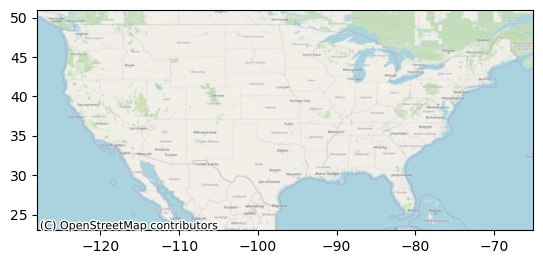

In [16]:
import geopandas as gpd
import contextily as cx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as pa
from matplotlib.lines import Line2D

long_min = - 128
long_max = -65
lat_min = 23
lat_max = 51

#collecte de la dataframe...
df = pd.read_csv('test_data.csv', parse_dates = ["Opening_date", "Closing_date"])
df = df[['Latitude', 'Longitude', 'State']]
df.head()

#conversion en geodataframe
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326')

fig, ax = plt.subplots() #gdf.plot(kind='scatter', y='Latitude', x='Longitude', s=magn_2, c=prof, edgecolors='k', linewidth = 0.6)
ax.set_xlim(long_min, long_max)
ax.set_ylim(lat_min, lat_max)
cx.add_basemap(ax, crs = gdf.crs, source=cx.providers.OpenStreetMap.Mapnik) #OpenStreetMap.Mapnik

plt.show()